In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OrdinalEncoder
from copulas.multivariate import GaussianMultivariate
from copulas.univariate import GaussianKDE
from copulas.univariate import GaussianUnivariate
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ks_2samp, wasserstein_distance
from copulas.visualization import compare_1d
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import chi2_contingency



In [2]:
RANDOM_SEED = 42

In [3]:
df = pd.read_parquet('data/raw/orderlines_dezember.parquet')[['Datum', 'Marktnummer', 'Artikelnummer', 'MengeInKolli', 'Markierung']]

df['order_id'] = df.groupby(['Marktnummer', 'Datum']).ngroup()

df = df.sample(n=10000, random_state=RANDOM_SEED)

In [5]:
df

,Datum,Marktnummer,Artikelnummer,MengeInKolli,Markierung,order_id
1642042,2024-12-31,44652484,1953777 0015,1,regional,3048
478386,2024-12-27,44400411,9530789 0012,1,regional,922
842498,2024-12-09,44401502,2388672 0009,1,regional,1467
985762,2024-12-04,44400142,1056372 0010,6,regional,309
707539,2024-12-21,44400198,8589069 0004,1,regional,550
...,...,...,...,...,...,...
659719,2024-12-12,44400890,8388793 0006,1,regional,1329
1528749,2024-12-05,44400386,8925182 0003,1,regional,868
1570580,2024-12-20,44656118,2181394 0006,9,regional,3460
1568788,2024-12-07,44400323,7222002 0006,1,regional,781


# Clustern auf Orderkopf ebene

In [6]:
df_cluster = df.copy()

# Marktnummer encoden
le = LabelEncoder()
df_cluster['Marktnummer_enc'] = le.fit_transform(df_cluster['Marktnummer'])

# Markierung encoden
df_cluster['Markierung_enc'] = le.fit_transform(df_cluster['Markierung'])

# Sortimente aus Artikelnummern nehmen
df_cluster['Artikelnummer_short'] = df_cluster['Artikelnummer'].astype(str).str[2:4]

In [7]:
cluster_feautures = df_cluster.groupby('order_id').agg({
    'Marktnummer_enc': 'first',
    'Artikelnummer_short': 'nunique',
    'MengeInKolli': 'mean',
    'Markierung_enc': 'first',
}).reset_index()

In [8]:
scalar = StandardScaler()
x_scaled = scalar.fit_transform(cluster_feautures)
    
kmeans = KMeans(n_clusters=5, random_state=RANDOM_SEED)
cluster_feautures['cluster'] = kmeans.fit_predict(x_scaled)

In [9]:
df = pd.merge(
    df,
    cluster_feautures[['order_id', 'cluster']],
    how='left',
    on='order_id'
)

# Orderkopf Generierung

In [10]:
def n_orders(df: pd.DataFrame):
    ziel_kolli = df.groupby('Datum')['MengeInKolli'].sum().mean()

    ziel_orders = df.groupby('Datum')['order_id'].nunique().mean()

    tage = df['Datum'].nunique()

    n_orders_tag = int(ziel_orders * tage)

    return n_orders_tag

n_orders_tag = n_orders(df)

In [11]:
def generate_orders(df: pd.DataFrame, n_orders = n_orders_tag):

    # 1. Gruppieren auf Bestell-Ebene
    order_df = df.groupby('order_id').agg({
        'Marktnummer': 'first',
        'Datum': 'first',
        'Artikelnummer': 'count', # Anzahl Orderlines zusammenfassen
        'cluster': 'first'  
    }).rename(columns={'Artikelnummer': 'orderlines'}).reset_index()

    allowed_dates = df['Datum'].unique()
    allowed_cluster = df['cluster'].unique()

    # 2. Datum zu numerischen Werten (Tage seit erstem Datum)
    order_df['Wochentag'] = pd.to_datetime(order_df['Datum']).dt.weekday
    order_df['Datum'] = pd.to_datetime(order_df['Datum'])
    min_date = order_df['Datum'].min()
    order_df['Datum'] = (order_df['Datum'] - min_date).dt.days


    # 3. Kategorische Spalte encoden und Encoder speichern
    le_markt = LabelEncoder()
    order_df['Marktnummer_enc'] = le_markt.fit_transform(order_df['Marktnummer'])


    # 4. Modell trainieren mit numerischen Spalten 
    model_order = GaussianMultivariate(distribution=GaussianKDE)
    model_order.fit(order_df[['Marktnummer_enc', 'Datum', 'Wochentag', 'orderlines', 'cluster']])


    # 5. Neue synthetische Orders generieren
    synthetic_orders = model_order.sample(n_orders)


    # 6. Rücktransformieren der kategorischen Spalte
    synthetic_orders['Marktnummer_enc'] = synthetic_orders['Marktnummer_enc'].clip(
        lower=0,
        upper=len(le_markt.classes_) - 1
    ).round().astype(int)
    synthetic_orders['Marktnummer'] = le_markt.inverse_transform(synthetic_orders['Marktnummer_enc'])
    synthetic_orders.drop(columns=['Marktnummer_enc'], inplace=True)


    # 7. Anzahl Positionen sauber machen (mindestens 1)
    synthetic_orders['orderlines'] = synthetic_orders['orderlines'].round().astype(int).clip(lower=1)

    # 8. Datum zurücktransformieren (numerisch)
    synthetic_orders['Datum_numeric'] = synthetic_orders['Datum']
    synthetic_orders['Datum'] = pd.to_datetime(synthetic_orders['Datum'], unit='D', origin=min_date)

    # Nearest-Neighbor-Mapping auf echte Tage
    allowed_dates = pd.to_datetime(sorted(df['Datum'].unique()))
    allowed_numeric = (allowed_dates - min_date).days.values

    synthetic_orders['Datum'] = synthetic_orders['Datum_numeric'].apply(
        lambda x: allowed_dates[np.argmin(np.abs(allowed_numeric - x))]
    ).dt.date

    # Nearest-Neighbour-Mapping auf echte cluster
    synthetic_orders['cluster_v2'] = synthetic_orders['cluster'].apply(
        lambda x: allowed_cluster[np.argmin(np.abs(allowed_cluster - x))]
    )

    synthetic_orders.drop(columns=['Datum_numeric', 'Wochentag', 'cluster'], inplace=True)


    return synthetic_orders




In [12]:
synthetic_orders = generate_orders(df)

synthetic_orders = synthetic_orders.rename(columns={'cluster_v2': 'cluster'})

# Zwischenauswertung Orderkopf Synthetisierung

In [13]:
def Zwischenauswertung(orig_df, synth_df):
    # 1. orig_df auf orderkopf aggregieren
    orig_df = orig_df.groupby('order_id').agg({
        'Marktnummer': 'first',
        'Datum': 'first',
        'Artikelnummer': 'count', # Anzahl Orderlines zusammenfassen
        'cluster': 'first'  
    }).rename(columns={'Artikelnummer': 'orderlines'}).reset_index()

    # Allgemeine Auswertung
    print(f'''Orderkopfbezogene Auswertung
        Anzahl Orders (real/synth) {len(orig_df)}, {len(synth_df)}
        Anzahl unterschiedlicher Tage (real/synth) {orig_df['Datum'].nunique()}, {synth_df['Datum'].nunique()}
        Summe orderlines (real/synth) {orig_df['orderlines'].sum()}, {synth_df['orderlines'].sum()}
        Anzahl unterschiedlicher Marktnummern (real/synth) {orig_df['Marktnummer'].nunique()}, {synth_df['Marktnummer'].nunique()}
        Anzahl orderlines pro Marktnummer (real / synth) {orig_df.groupby('Marktnummer')['orderlines'].sum().mean()},{synth_df.groupby('Marktnummer')['orderlines'].sum().mean()}
        Anzahl orderlines pro Tag (real/synth) {orig_df.groupby('Datum')['orderlines'].sum().mean()}, {synth_df.groupby('Datum')['orderlines'].sum().mean()}\n''')

    
    # Verteilungen Auswertung
    print(f'''Verteilungen Auswertung
        Kolmogorov Test orderlines: {ks_2samp(orig_df['orderlines'], synth_df['orderlines'])}
        Wasserstein-Distanz orderlines: {wasserstein_distance(orig_df['orderlines'], synth_df['orderlines'])}''')

    # Visueller Vergleich Cluster
    orig_df_cluster = orig_df.groupby('cluster')['orderlines'].sum().reset_index()
    orig_df_cluster['category'] = 'real'
    synth_df_cluster = synth_df.groupby('cluster')['orderlines'].sum().reset_index()
    synth_df_cluster['category'] = 'synth'
    cluster_compare = pd.concat([orig_df_cluster, synth_df_cluster], ignore_index=True)

    # Visueller Vergleich Datum
    orig_df_date = orig_df.groupby('Datum')['orderlines'].sum().reset_index().sort_values(by='Datum')
    synth_df_date = synth_df.groupby('Datum')['orderlines'].sum().reset_index().sort_values(by='Datum')

    # Subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 7))
    axes = axes.flatten()

    # 1. Balkendiagramm: orderlines pro cluster
    sns.barplot(data=cluster_compare, x='cluster', y='orderlines', hue='category', ax=axes[0])
    axes[0].set_title("Orderlines pro Cluster")
    axes[0].set_ylabel("Summe Orderlines")

    # 2. ECDF
    sns.ecdfplot(data=orig_df, x='orderlines', label='Original', ax=axes[1])
    sns.ecdfplot(data=synth_df, x='orderlines', label='Synthetisch', ax=axes[1])
    axes[1].set_title("Verteilung der Orderlines")
    axes[1].set_xlabel("Orderlines pro Bestellung")
    axes[1].legend()

    # 3. Zeitverlauf
    sns.lineplot(data=orig_df_date, x='Datum', y='orderlines', label='Original', ax=axes[2])
    sns.lineplot(data=synth_df_date, x='Datum', y='orderlines', label='Synthetisch', ax=axes[2])
    axes[2].set_title("Orderlines über Zeit")
    axes[2].set_ylabel("Orderlines")
    axes[2].legend()

    # Optional: 4. Plot freilassen oder für weitere Metriken nutzen
    axes[3].axis('off')  # leer lassen, falls nicht verwendet

    plt.tight_layout()
    plt.show()

Orderkopfbezogene Auswertung
        Anzahl Orders (real/synth) 3010, 3010
        Anzahl unterschiedlicher Tage (real/synth) 24, 24
        Summe orderlines (real/synth) 10000, 9931
        Anzahl unterschiedlicher Marktnummern (real/synth) 367, 367
        Anzahl orderlines pro Marktnummer (real / synth) 27.247956403269754,27.059945504087192
        Anzahl orderlines pro Tag (real/synth) 416.6666666666667, 413.7916666666667

Verteilungen Auswertung
        Kolmogorov Test orderlines: KstestResult(statistic=np.float64(0.006644518272425249), pvalue=np.float64(0.9999999175970262), statistic_location=np.int64(3), statistic_sign=np.int8(-1))
        Wasserstein-Distanz orderlines: 0.02890365448504964


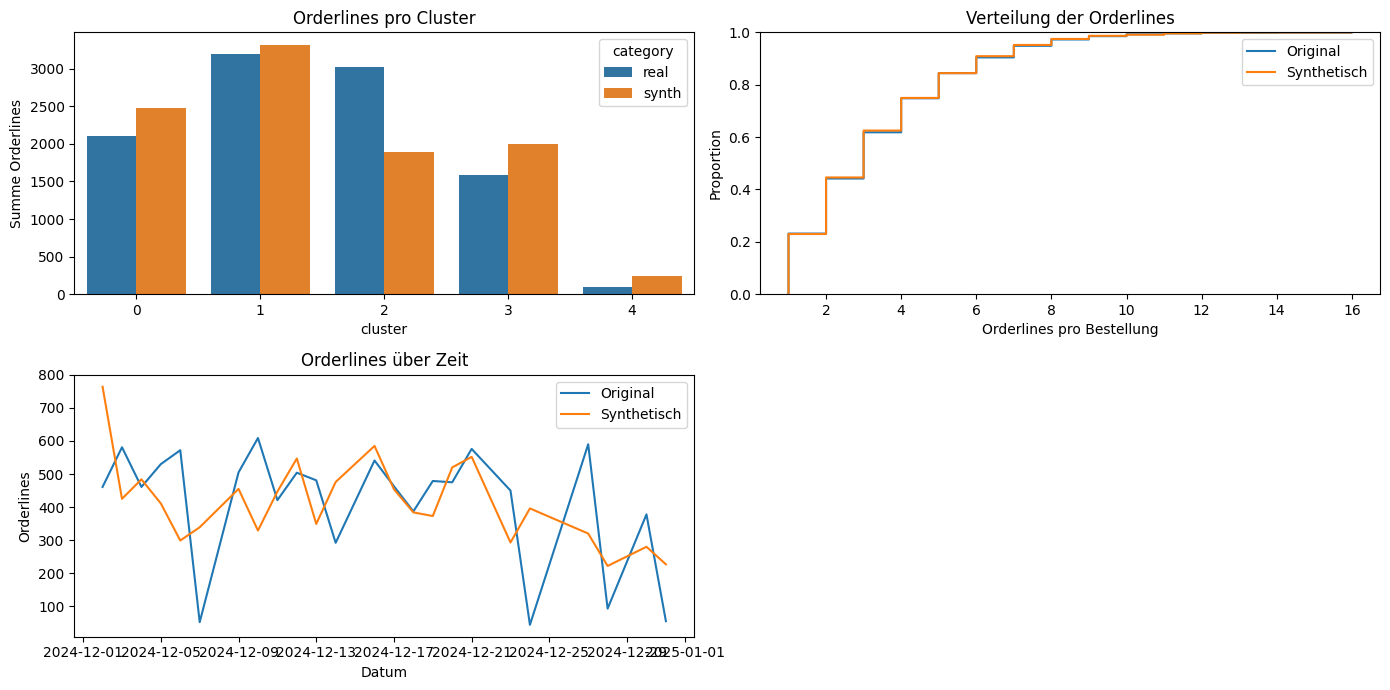

In [14]:
Zwischenauswertung(df, synthetic_orders)

# Orderline Generierung Cluster Lokal

In [15]:
def generate_orderline_local(orig_df:pd.DataFrame, synthetic_orders:pd.DataFrame):
      
     # 1. Relevante Spalten extrahieren
    orig_df = orig_df[['Artikelnummer', 'MengeInKolli', 'Markierung', 'cluster']].copy()

    # cluster
    allowed_cluster = orig_df['cluster'].unique()

    # 2. Encoding
    le_artikel = LabelEncoder()
    le_markierung = LabelEncoder()
    orig_df['Artikelnummer_enc'] = le_artikel.fit_transform(orig_df['Artikelnummer'])
    orig_df['Markierung_enc'] = le_markierung.fit_transform(orig_df['Markierung'])

    # cluster zählungen
    cluster_count = synthetic_orders.groupby('cluster')['orderlines'].sum()

    # liste zum speichern der orderlines
    synthetic_positions_list = []

    for cluster in allowed_cluster:
        cluster_df = orig_df[orig_df['cluster'] == cluster]
        n_orderlines = cluster_count.get(cluster, 0)

        model = GaussianMultivariate(distribution=GaussianKDE)
        model.fit(cluster_df[['Markierung_enc', 'Artikelnummer_enc', 'MengeInKolli']])

        synthetic_cluster_positions = model.sample(n_orderlines)

      # Rücktransformation
        synthetic_cluster_positions['Artikelnummer_enc'] = synthetic_cluster_positions['Artikelnummer_enc'].clip(
            lower=0, upper=len(le_artikel.classes_) - 1).round().astype(int)
        synthetic_cluster_positions['Markierung_enc'] = synthetic_cluster_positions['Markierung_enc'].clip(
            lower=0, upper=len(le_markierung.classes_) - 1).round().astype(int)
        synthetic_cluster_positions['MengeInKolli'] = synthetic_cluster_positions['MengeInKolli'].clip(lower=1).round()

        synthetic_cluster_positions['Artikelnummer'] = le_artikel.inverse_transform(synthetic_cluster_positions['Artikelnummer_enc'])
        synthetic_cluster_positions['Markierung'] = le_markierung.inverse_transform(synthetic_cluster_positions['Markierung_enc'])

        synthetic_cluster_positions['cluster_v3'] = cluster

        synthetic_cluster_positions = synthetic_cluster_positions[['Artikelnummer', 'Markierung', 'MengeInKolli', 'cluster_v3']]

        synthetic_positions_list.append(synthetic_cluster_positions)

    # 6. Combine all
    if synthetic_positions_list:
        synthetic_positions_df = pd.concat(synthetic_positions_list, ignore_index=True)
    else:
        synthetic_positions_df = pd.DataFrame(columns=['Artikelnummer', 'Markierung', 'MengeInKolli', 'cluster_v3'])

    return synthetic_positions_df



In [16]:
synth_orderlines = generate_orderline_local(df,synthetic_orders)

synth_orderlines = synth_orderlines.rename(columns={'cluster_v3': 'cluster'})

In [17]:
def assign_orderlines_to_orders(synthetic_orders: pd.DataFrame, synth_orderlines: pd.DataFrame) -> pd.DataFrame:
    """
    Fügt den generierten Orderlines die passende Order-ID der synthetischen Orders hinzu,
    basierend auf der Cluster-Zugehörigkeit und Anzahl gewünschter Orderlines pro Order.
    """

    # Liste zum Speichern der finalen Orderlines
    assigned_orderlines = []

    # Index für fortlaufende Orderline-Zuweisung (damit wir nicht immer von vorne nehmen)
    current_idx = {cluster: 0 for cluster in synthetic_orders['cluster'].unique()}

    # Wir sortieren die Orderlines nach Cluster für effizienteren Zugriff
    synth_orderlines = synth_orderlines.sort_values(by='cluster').reset_index(drop=True)

    for i, row in synthetic_orders.iterrows():
        cluster = row['cluster']
        n_lines = row['orderlines']
        order_id = f'synth_{i}'  # Neue eindeutige Order-ID für synthetische Orders

        # Alle Orderlines aus diesem Cluster
        cluster_lines = synth_orderlines[synth_orderlines['cluster'] == cluster]

        start_idx = current_idx[cluster]
        end_idx = start_idx + n_lines

        # Sicherstellen, dass wir nicht über das Ende hinausgehen
        if end_idx > len(cluster_lines):
            end_idx = len(cluster_lines)

        selected_lines = cluster_lines.iloc[start_idx:end_idx].copy()
        selected_lines['order_id'] = order_id
        selected_lines['Datum'] = row['Datum']
        selected_lines['Marktnummer'] = row['Marktnummer']

        # Speichern und Index aktualisieren
        assigned_orderlines.append(selected_lines)
        current_idx[cluster] = end_idx

    # Zusammenführen
    if assigned_orderlines:
        final_df = pd.concat(assigned_orderlines, ignore_index=True)
    else:
        final_df = pd.DataFrame()

    return final_df


synth_orderlines = assign_orderlines_to_orders(synthetic_orders, synth_orderlines)


# Auswertung Orderline Generierung Cluster Lokal

In [18]:

def Auswertung(original_orderlines:pd.DataFrame, synth_orderlines:pd.DataFrame):

    # Vergleich auf Orderline Ebene
    orig_sum_menge = original_orderlines.groupby('cluster')['MengeInKolli'].sum()
    synth_sum_menge = synth_orderlines.groupby('cluster')['MengeInKolli'].sum()

    orig_count_artikel = original_orderlines.groupby('cluster')['Artikelnummer'].count()
    synth_count_artikel = synth_orderlines.groupby('cluster')['Artikelnummer'].count()

    orig_sum_menge_tag = original_orderlines.groupby('Datum')['MengeInKolli'].sum()
    synth_sum_menge_tag = synth_orderlines.groupby('Datum')['MengeInKolli'].sum()

    orig_count_artikel_day = original_orderlines.groupby('Datum')['Artikelnummer'].count()
    synth_count_artikel_day = synth_orderlines.groupby('Datum')['Artikelnummer'].count()

    print(f'''Orderline bezogen Auswertung
    Summe MengeInKolli (real/synth): {original_orderlines['MengeInKolli'].sum()} , {synth_orderlines['MengeInKolli'].sum()}
    Durchschnitt MengeInKolli (real/synth): {original_orderlines['MengeInKolli'].mean()}, {synth_orderlines['MengeInKolli'].mean()}
    Durschnitt MengeInKolli pro Cluster (real/synth): {orig_sum_menge.mean()}, {synth_sum_menge.mean()}
    Durschnitt Anzahl Artikelnummern pro Cluster (real/synth): {orig_count_artikel.mean()}, {synth_count_artikel.mean()}\n''')

    print(f'''Tagesbezogene Auswertung
    Summe MengeInKolli pro Tag (real/synth): {orig_sum_menge_tag.mean()}, {synth_sum_menge_tag.mean()}
    Durchschnitt Artikelnummern pro Tag (real/synth): {orig_count_artikel_day.mean()}, {synth_count_artikel_day.mean()} \n''')
    
    # Auswertung der Verteilung
    print(f'''Verteilung Auswertung
    FALSCHE ANWENDUNG Kolmogorov Test (MengeInKolli) pro Cluster: {ks_2samp(orig_sum_menge, synth_sum_menge)}
    FALSCHE ANWENDUNG Wasserstein-Distanz (MengeInKolli) pro Cluster: {wasserstein_distance(orig_sum_menge, synth_sum_menge)}
    FALSCHE ANWENDUNG Kolmogorov Test (Artikelnummern) pro Cluster: {ks_2samp(orig_count_artikel, synth_count_artikel)}
    FALSCHE ANWENDUNG Wasserstein-Distanz (Artikelnummern) pro Cluster: {wasserstein_distance(orig_count_artikel, synth_count_artikel)}
    ''')
    
    #Kolmogorov-Sminov-Test
    print(f"Kolmogorov Test (MengeInKolli): {ks_2samp(original_orderlines['MengeInKolli'], synth_orderlines['MengeInKolli'])}")

    # Wasserstein Distanz Test
    print(f"Wasserstein-Distanz (MengeInKolli): {wasserstein_distance(original_orderlines['MengeInKolli'], synth_orderlines['MengeInKolli'])}\n")

    #Anwendung chi2 test auf Markierung
    real_counts = original_orderlines.value_counts().sort_index()
    synth_counts = synth_orderlines.value_counts().sort_index()

    contingency_table = pd.concat([real_counts, synth_counts], axis=1)
    contingency_table.columns = ['real', 'synth']
    contingency_table.fillna(0, inplace=True)

    chi2, p_value, dof, expected = chi2_contingency(contingency_table.T)

    print(f"Chi²-Statistik (Markierung): {chi2}")
    print(f"p-Wert (Markierung): {p_value}")

    # Vorbereitung plots
    original_orderlines_cluster = original_orderlines.groupby('cluster')['MengeInKolli'].sum().reset_index()
    original_orderlines_cluster['category'] = 'real'
    synth_orderlines_cluster = synth_orderlines.groupby('cluster')['MengeInKolli'].sum().reset_index()
    synth_orderlines_cluster['category'] = 'synth'
    cluster_compare = pd.concat([original_orderlines_cluster, synth_orderlines_cluster])

    orig_df_date = original_orderlines.groupby('Datum')['MengeInKolli'].sum().reset_index()
    synth_df_date = synth_orderlines.groupby('Datum')['MengeInKolli'].sum().reset_index()

    orig_hist = original_orderlines.groupby('order_id')['MengeInKolli'].sum().reset_index()
    orig_hist['category'] = 'real'
    synth_hist = synth_orderlines.groupby('order_id')['MengeInKolli'].sum().reset_index()
    synth_hist['category'] = 'synth'
    concat_hist = pd.concat([synth_hist, orig_hist])
    concat_hist['order_id'] = concat_hist['order_id'].astype(str)


    # Subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 7))
    axes = axes.flatten()

    # 1. Balkendiagramm: menge pro cluster
    sns.barplot(data=cluster_compare, x='cluster', y='MengeInKolli', hue='category', ax=axes[0])
    axes[0].set_title("MengeInKolli pro Cluster")
    axes[0].set_ylabel("Summe Kolli")

    # 2. ECDF
    sns.ecdfplot(data=original_orderlines, x='MengeInKolli', label='Original', ax=axes[1])
    sns.ecdfplot(data=synth_orderlines, x='MengeInKolli', label='Synthetisch', ax=axes[1])
    axes[1].set_title("Verteilung der MengeInKolli auf Orderline Ebene")
    axes[1].set_xlabel("MengeInKolli pro Orderline")
    axes[1].legend()

   # 3. Zeitverlauf
    sns.lineplot(data=orig_df_date, x='Datum', y='MengeInKolli', label='Original', ax=axes[2])
    sns.lineplot(data=synth_df_date, x='Datum', y='MengeInKolli', label='Synthetisch', ax=axes[2])
    axes[2].set_title("MengeInKolli über Zeit")
    axes[2].set_ylabel("MengeInKolli")
    axes[2].legend()


    # Histogramm Kolii pro Orderlines
    sns.histplot(
    data=concat_hist, x='MengeInKolli', hue='category', ax=axes[3], bins=30, multiple='dodge')
    axes[3].set_title('Histogramm MengeInKolli pro Order')
    #axes[3].axis('off')  # leer lassen, falls nicht verwendet

    plt.show()

    

Orderline bezogen Auswertung
    Summe MengeInKolli (real/synth): 14274 , 15765.0
    Durchschnitt MengeInKolli (real/synth): 1.4274, 1.5874534286577384
    Durschnitt MengeInKolli pro Cluster (real/synth): 2854.8, 3153.0
    Durschnitt Anzahl Artikelnummern pro Cluster (real/synth): 2000.0, 1986.2

Tagesbezogene Auswertung
    Summe MengeInKolli pro Tag (real/synth): 594.75, 656.875
    Durchschnitt Artikelnummern pro Tag (real/synth): 416.6666666666667, 413.7916666666667 

Verteilung Auswertung
    FALSCHE ANWENDUNG Kolmogorov Test (MengeInKolli) pro Cluster: KstestResult(statistic=np.float64(0.4), pvalue=np.float64(0.873015873015873), statistic_location=np.float64(2056.0), statistic_sign=np.int8(1))
    FALSCHE ANWENDUNG Wasserstein-Distanz (MengeInKolli) pro Cluster: 697.0
    FALSCHE ANWENDUNG Kolmogorov Test (Artikelnummern) pro Cluster: KstestResult(statistic=np.float64(0.2), pvalue=np.float64(1.0), statistic_location=np.int64(2478), statistic_sign=np.int8(-1))
    FALSCHE ANWEN

c:\Users\fabik\OneDrive\Projekte\gaussian_copula_bachelor_thesis\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


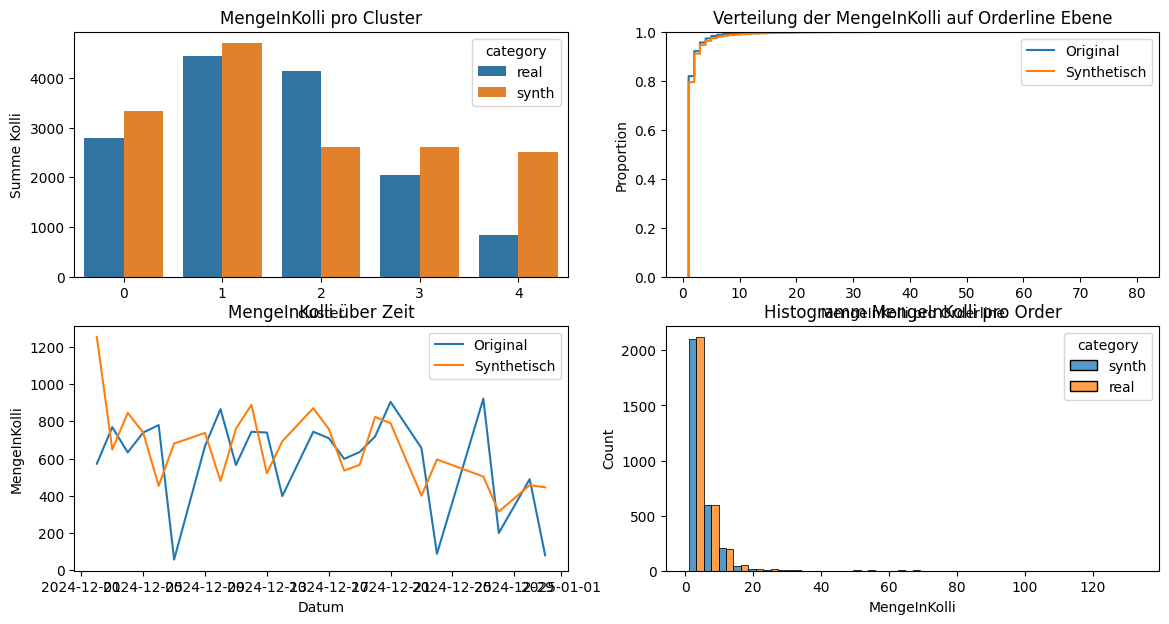

In [19]:
Auswertung(df, synth_orderlines)

In [20]:
# def auswerten_lang(orig_df, synth_df):
#     df_clipped = orig_df[['Artikelnummer', 'MengeInKolli', 'Markierung', 'cluster']]
#     i = 0
#     for i in range(5):
#         print(f"\n--- Auswertung Iteration {i+1} ---\n")
#         synth_orderlines = generate_orderline_local(orig_df, synth_df)
#         synth_orderlines = synth_orderlines.rename(columns={'cluster_v3': 'cluster'})
#         Auswertung(df_clipped, synth_orderlines)

# auswerten_lang(df, synthetic_orders)


In [21]:
df

,Datum,Marktnummer,Artikelnummer,MengeInKolli,Markierung,order_id,cluster
0,2024-12-31,44652484,1953777 0015,1,regional,3048,1
1,2024-12-27,44400411,9530789 0012,1,regional,922,0
2,2024-12-09,44401502,2388672 0009,1,regional,1467,0
3,2024-12-04,44400142,1056372 0010,6,regional,309,2
4,2024-12-21,44400198,8589069 0004,1,regional,550,0
...,...,...,...,...,...,...,...
9995,2024-12-12,44400890,8388793 0006,1,regional,1329,0
9996,2024-12-05,44400386,8925182 0003,1,regional,868,0
9997,2024-12-20,44656118,2181394 0006,9,regional,3460,3
9998,2024-12-07,44400323,7222002 0006,1,regional,781,2


# 30 Iterationen

In [22]:
def eval_iterations(orig_df: pd.DataFrame, n_iter: int = 2):
    results = []

    for i in range(n_iter):
        print(f"\n--- Iteration {i+1} ---")

        # n_orders pro tag bestimmen
        n_orders_tag = n_orders(df)

        # 1. Orders generieren
        synth_orders = generate_orders(orig_df, n_orders = n_orders_tag)
        synth_orders = synth_orders.rename(columns={'cluster_v2': 'cluster'})

        # 2. Orderlines generieren
        synth_orderlines = generate_orderline_local(orig_df, synth_orders)
        synth_orderlines = synth_orderlines.rename(columns={'cluster_v3': 'cluster'})

        synth_orderlines = assign_orderlines_to_orders(synth_orders, synth_orderlines)

        # Orderlines gruppieren real
        orig_orderkopf = orig_df.groupby('order_id').agg({
            'Datum': 'first',
            'Marktnummer': 'first',
            'Artikelnummer': 'count',
            'MengeInKolli': 'sum'
        }).rename(columns={'Artikelnummer': 'orderlines'})

        # 5. Statistiken berechnen
        res = {
            'iteration': i + 1,
            'orders_real': len(orig_orderkopf),
            'orders_synth': len(synth_orders),
            'nunique_datum_synth': synth_orders['Datum'].nunique(),
            'nunique_datum_real': orig_df['Datum'].nunique(),
            'sum_orderlines_real': orig_orderkopf['orderlines'].sum(),
            'sum_orderlines_synth': synth_orders['orderlines'].sum(),
            'wasserstein_orderlines': wasserstein_distance(orig_orderkopf['orderlines'], synth_orders['orderlines']),
            'ks_orderlines': ks_2samp(orig_orderkopf['orderlines'], synth_orders['orderlines']).statistic,

            'sum_menge_real': orig_df['MengeInKolli'].sum(),
            'sum_menge_synth': synth_orderlines['MengeInKolli'].sum(),
            'mean_menge_real': orig_df['MengeInKolli'].mean(),
            'mean_menge_synth': synth_orderlines['MengeInKolli'].mean(),
            'wasserstein_menge': wasserstein_distance(orig_df['MengeInKolli'], synth_orderlines['MengeInKolli']),
            'ks_menge': ks_2samp(orig_df['MengeInKolli'], synth_orderlines['MengeInKolli']).statistic,
        }

        results.append(res)

    # Am Ende: Alles als DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [23]:
results_df = eval_iterations(df)


--- Iteration 1 ---


KeyboardInterrupt: 

In [ ]:
results_df

In [ ]:
results_df.to_csv('results_gc.csv', index=False)